In [1]:
import json
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, recall_score
from matplotlib import pyplot as plt
import seaborn as sns

from kloppy import (
    metrica, wyscout
)

from utils import (
    plot_confusion_matrix,
    get_frame_data,
    plot_accuracy_history,
    calculate_player_ball_distances,
    track_closest_players,
    get_n_smallest_indices_sorted
)

In [2]:
games = [2576322, 2576323, 2576324, 2576325, 2576326, 2576327, 2576328, 2576329, 2576330, 2576331, 2576333, 2576334, 2576335, 2576336, 2576337, 2576338, 2576290, 2576291, 2576292, 2576293, 2576294, 2576295, 2576296, 
         2576297, 2576298, 2576299, 2576300, 2576301, 2576302, 2576303, 2576304, 2576305, 2576306, 2576307, 2576308, 2576272, 2576273, 2576274, 2576275, 2576276, 2576277, 2576278, 2576279, 2576280, 2576282, 2576283, 
         2576284, 2576285, 2576286, 2576287, 2576288, 2576289, 2516893, 2516894, 2516895, 2516896, 2516897, 2516898, 2516899, 2516900, 2516901, 2516902, 2516903, 2516904, 2516905, 2516906, 2516907, 2516908, 2516909, 
         2516910, 2516911, 2516912, 2516873, 2516874, 2516875, 2516876, 2516877, 2516878, 2516879, 2516880, 2516881, 2516882, 2516883,]
test_games = [ 2516884, 2516885, 2516886, 2516887, 2516888, 2516889, 2516890, 2516891, 2516892,
         2516913, 2516914, 2516915, 2516916, 2516917, 2516918, 2516919, 2516920, 2516921, 2516922, 2516923, 2516924, 2516926, 2516927, 2516928, 2516929, 2516930, 2516931, 2516932]
np.unique(games).shape[0], len(games)
len(test_games)

28

In [18]:
def game_loader(matches):
    result = pd.DataFrame([])
    for i in matches:
        dataset = wyscout.load_open_data(match_id=i)
        game = dataset.to_df()
        temp_game = game.copy()
        return temp_game
        temp_game.dropna(axis=1, how="all", inplace=True)
        temp_game = temp_game[["event_type", "coordinates_x", "coordinates_y", "end_coordinates_x", "end_coordinates_y"]]
        temp_game = temp_game[~(temp_game["event_type"] == "GENERIC:generic")]
        
        cols_with_nan = temp_game.columns[temp_game.isnull().any()]
        for col in cols_with_nan:
            idxs = temp_game[temp_game[col].isnull()].index
            if col.endswith("x"):
                temp_game.loc[idxs, col] = temp_game.loc[idxs, "coordinates_x"]
            elif col.endswith("y"):
                temp_game.loc[idxs, col] = temp_game.loc[idxs, "coordinates_y"]

        result = pd.concat([result, temp_game])
        
    return result

In [19]:
train_results = game_loader(games)
test_result = game_loader(test_games)

In [23]:
train_results.iloc[:, 5:]

,timestamp,end_timestamp,ball_state,ball_owning_team,team_id,player_id,coordinates_x,coordinates_y,end_coordinates_x,end_coordinates_y,receiver_player_id,is_counter_attack,pass_type,duel_type,body_part_type,set_piece_type,card_type,goalkeeper_type
0,0 days 00:00:04.602025,None,None,None,3159,134427,0.335873,0.388403,0.664127,0.085697,None,False,HIGH_PASS,None,None,None,None,None
1,0 days 00:00:07.726425,None,None,None,3158,3463,0.335873,0.914303,NaN,NaN,None,False,None,AERIAL,None,None,None,None
2,0 days 00:00:07.949310,None,None,None,3159,14943,0.664127,0.085697,NaN,NaN,None,False,None,AERIAL,None,None,None,None
3,0 days 00:00:10.097552,None,None,None,3159,70084,0.767905,0.021424,NaN,NaN,None,False,None,None,None,None,None,None
4,0 days 00:00:11.089452,None,None,None,3158,22566,0.203792,0.946440,0.373610,0.925015,None,False,LAUNCH,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1726,0 days 00:46:35.010226,None,None,None,3158,22566,0.711299,0.828607,0.965079,0.935728,None,False,HEAD_PASS,None,HEAD,None,None,None
1727,0 days 00:46:37.503337,None,None,None,3158,234359,0.965079,0.935728,NaN,NaN,None,False,None,GROUND,None,None,None,None
1728,0 days 00:46:38.676274,None,None,None,3159,20458,0.034921,0.064272,NaN,NaN,None,False,None,GROUND,None,None,None,None
1729,0 days 00:46:42.834483,None,None,None,3158,None,0.973810,1.000000,NaN,NaN,None,False,None,None,None,None,None,None


In [5]:
train_results["event_type"].value_counts()

event_type
PASS              80625
DUEL              37825
INTERCEPTION       7384
BALL_OUT           5939
RECOVERY           5497
CLEARANCE          2445
FOUL_COMMITTED     2206
SHOT               1974
GOALKEEPER          774
MISCONTROL          583
CARD                334
Name: count, dtype: int64

In [6]:
test_result["event_type"].value_counts()

event_type
PASS              26874
DUEL              13317
INTERCEPTION       2609
BALL_OUT           1984
RECOVERY           1815
FOUL_COMMITTED      811
CLEARANCE           809
SHOT                666
GOALKEEPER          262
MISCONTROL          145
CARD                110
Name: count, dtype: int64

In [7]:
events_to_leave_out = ["DUEL", "FOUL_COMMITTED", "GOALKEEPER", "MISCONTROL", "CARD"]

new_train_results = train_results[~(train_results["event_type"].isin(events_to_leave_out))]
new_train_results = new_train_results.replace(["INTERCEPTION", "RECOVERY", "CLEARANCE"], "BALL LOST")

new_test_results = test_result[~(test_result["event_type"].isin(events_to_leave_out))]
new_test_results = new_test_results.replace(["INTERCEPTION", "RECOVERY", "CLEARANCE"], "BALL LOST")

In [8]:
new_train_results["event_type"].value_counts()

event_type
PASS         80625
BALL LOST    15326
BALL_OUT      5939
SHOT          1974
Name: count, dtype: int64

In [10]:
new_test_results["event_type"].value_counts()

event_type
PASS         26874
BALL LOST     5233
BALL_OUT      1984
SHOT           666
Name: count, dtype: int64

In [11]:
# X, y = new_results.loc[:, ["coordinates_x", "coordinates_y", "end_coordinates_x", "end_coordinates_y"]], new_results.loc[:, "event_type"]
# X.shape, y.shape

In [12]:
X_train, y_train = new_train_results.loc[:, ["coordinates_x", "coordinates_y", "end_coordinates_x", "end_coordinates_y"]], new_train_results.loc[:, "event_type"]
X_test, y_test = new_test_results.loc[:, ["coordinates_x", "coordinates_y", "end_coordinates_x", "end_coordinates_y"]], new_test_results.loc[:, "event_type"]

In [13]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [14]:
np.unique(y, return_counts=True)

NameError: name 'y' is not defined

In [16]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array(['BALL LOST', 'BALL_OUT', 'PASS', 'SHOT'], dtype=object), array([15326,  5939, 80625,  1974], dtype=int64))
(array(['BALL LOST', 'BALL_OUT', 'PASS', 'SHOT'], dtype=object), array([ 5233,  1984, 26874,   666], dtype=int64))


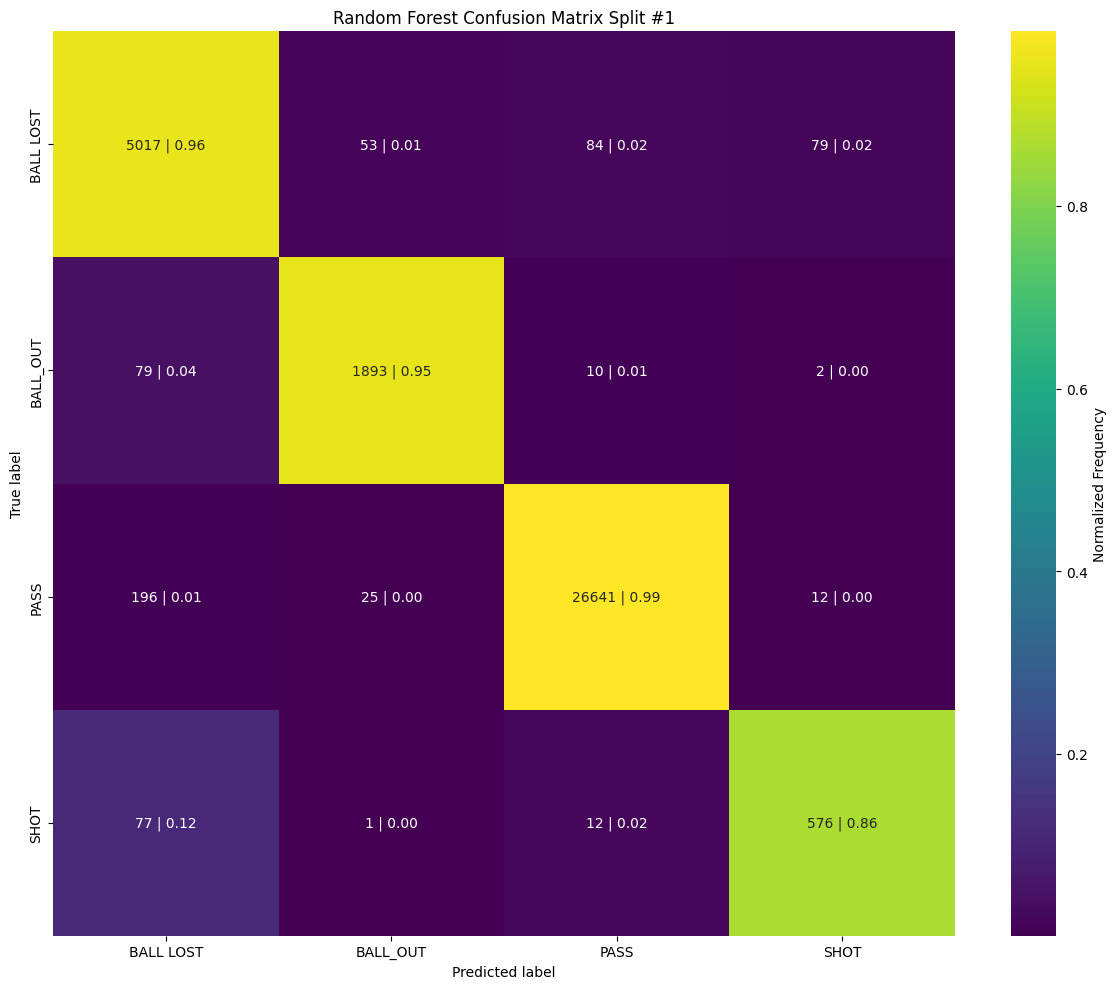

Random Forest training accuracy: 99.36%
Random Forest testing accuracy: 98.19%

Random Forest testing precision: 98.21%
Random Forest testing recall: 98.19%
Random Forest testing f1: 98.20%




In [17]:
model = RandomForestClassifier(n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

labels = np.unique(y_train)
        
fig = plot_confusion_matrix(y_train=y_train, y_train_pred=y_train_pred, y_test=y_test, 
                      y_pred=y_test_pred, labels=labels, split=0, model_name="Random Forest")

fig.savefig(f"wyscout.png", bbox_inches="tight")

In [2]:
from preprocessing import PreProcessing

game_1_pre = PreProcessing()
game_1_data = game_1_pre.load_and_process_data(
    data_home="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv", 
    data_away="data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv", 
    add_ball_data=True, 
    remove_ball_nan=False
)

game_2_pre = PreProcessing()
game_2_data = game_2_pre.load_and_process_data(
    data_home="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Home_Team.csv", 
    data_away="data/Sample_Game_2/Sample_Game_2_RawTrackingData_Away_Team.csv", 
    add_ball_data=True, 
    remove_ball_nan=False
)

game_3_data = pd.read_csv("data/Sample_Game_3/Sample_Game_3_tracking.txt", sep=r"[;,:]", header=None, engine="python")
game_3_data.index =  range(1, len(game_3_data) + 1)
time = np.arange(0.04, (len(game_3_data) + 1) * 0.04, 0.04).round(2)
game_3_data.insert(1, "Time [s]", time)
columns = ['Frame', 'Time [s]', 'Home-Player11-x', 'Home-Player11-y', 'Home-Player1-x', 'Home-Player1-y', 'Home-Player2-x', 'Home-Player2-y',
       'Home-Player3-x', 'Home-Player3-y', 'Home-Player4-x', 'Home-Player4-y', 'Home-Player5-x', 'Home-Player5-y', 'Home-Player6-x', 'Home-Player6-y',
       'Home-Player7-x', 'Home-Player7-y', 'Home-Player8-x', 'Home-Player8-y', 'Home-Player9-x', 'Home-Player9-y', 'Home-Player10-x',
       'Home-Player10-y', 'Away-Player25-x', 'Away-Player25-y', 'Away-Player15-x', 'Away-Player15-y', 'Away-Player16-x',
       'Away-Player16-y', 'Away-Player17-x', 'Away-Player17-y', 'Away-Player18-x', 'Away-Player18-y', 'Away-Player19-x',
       'Away-Player19-y', 'Away-Player20-x', 'Away-Player20-y', 'Away-Player21-x', 'Away-Player21-y', 'Away-Player22-x',
       'Away-Player22-y', 'Away-Player23-x', 'Away-Player23-y', 'Away-Player24-x', 'Away-Player24-y', "Ball-x", "Ball-y"]

game_3_data.columns = columns
game_3_data = game_2_pre._fill_missing_with_interpolation_and_fill(game_3_data)

In [3]:
def process_event_data(event_data, full_data, cols):
    ball_out_idx = full_data.index[
        (full_data["Ball-x"] < 0) | (full_data["Ball-x"] > 1) |
        (full_data["Ball-y"] < 0) | (full_data["Ball-y"] > 1)
    ]

    ball_out_df = pd.DataFrame({
        "Type": "BALL OUT"
    }, index=ball_out_idx)

    event_data = event_data[~(event_data["Type"] == "BALL OUT")]
    start_frames = event_data["Start Frame"].iloc[1:].to_numpy()
    end_frames = event_data["End Frame"].iloc[1:].to_numpy()
    event_types = event_data[cols].iloc[1:].to_numpy()

    # Validation
    # assert start_frames.shape == end_frames.shape == event_types.shape

    # Ensure end frames don't exceed data bounds
    end = full_data.index[-1]
    end_frames = np.minimum(end_frames, end)

    # Create frame ranges and unique indices
    frame_ranges = [np.arange(min(i, j), max(i, j) + 1)
                    for i, j in zip(start_frames, end_frames)]
    unique_indices = np.unique(np.concatenate(frame_ranges))

    # Create and populate event DataFrame
    event_df = pd.DataFrame(index=unique_indices, columns=cols)
    for s, e, e_t in zip(start_frames, end_frames, event_types):
        event_df.loc[s:e, cols] = e_t

    combined_event_df = ball_out_df.combine_first(event_df)

    return combined_event_df

In [4]:
def prepare_event_data(data, game_data, events_to_leave_out=["FAULT RECEIVED", "SET PIECE", "CARD", "CHALLENGE"]):
    game_event_data = pd.read_csv(data)    
    game_event_data = game_event_data[~(game_event_data["Type"].isin(events_to_leave_out))]
    game_event_data = game_event_data.replace("RECOVERY", "BALL LOST")    
    game_event_data = game_event_data[["Type", "Start Frame", "End Frame", "Start X", "Start Y", "End X", "End Y"]]
    game_event = process_event_data(game_event_data, game_data, ["Type", "Start X", "Start Y", "End X", "End Y"])
    
    return game_event

In [5]:
def prepare_json_event_data(data, game_data, events_to_leave_out=["FAULT RECEIVED", "SET PIECE", "CARD", "CHALLENGE"]):
    with open(data, "r") as f:
        event = json.load(f)
        
    type_ = np.array([])
    start_frame = np.array([])
    end_frame = np.array([])
    s_x_ = np.array([])
    s_y_ = np.array([])
    e_x_ = np.array([])
    e_y_ = np.array([])

    for i in event["data"]:
        t = i["type"]["name"]
        sf = i["start"]["frame"]
        ef = i["end"]["frame"]
        s_x = i["start"]["x"]
        s_y = i["start"]["y"]
        e_x = i["end"]["x"]
        e_y = i["end"]["y"]
    
        if t != "CARRY" and t != "BALL OUT":
            type_ = np.append(type_, t)
            start_frame = np.append(start_frame, sf)
            end_frame = np.append(end_frame, ef)
            s_x_ = np.append(s_x_, s_x)
            s_y_ = np.append(s_y_, s_y)
            e_x_ = np.append(e_x_, e_x)
            e_y_ = np.append(e_y_, e_y)
    
    s_x_ = np.nan_to_num(np.array(s_x_, dtype=float))
    s_y_ = np.nan_to_num(np.array(s_y_, dtype=float))
    e_x_ = np.nan_to_num(np.array(e_x_, dtype=float))
    e_y_ = np.nan_to_num(np.array(e_y_, dtype=float))

    game_event_data = pd.DataFrame(
        {
            "Type": type_, 
            "Start Frame": start_frame.astype(np.int64), 
            "End Frame": end_frame.astype(np.int64),
            "Start X": s_x_, 
            "Start Y": s_y_,
            "End X": e_x_, 
            "End Y": e_y_
        }
    )
    game_event_data = game_event_data[~(game_event_data["Type"].isin(events_to_leave_out))]
    
    game_event_data = game_event_data.replace("RECOVERY", "BALL LOST")
    game_event = process_event_data(game_event_data, game_data, ["Type", "Start X", "Start Y", "End X", "End Y"])
    
    return game_event

In [6]:
game_1_event = prepare_event_data("data/Sample_Game_1/Sample_Game_1_RawEventsData.csv", game_1_data).fillna(0.0)
game_2_event = prepare_event_data("data/Sample_Game_2/Sample_Game_2_RawEventsData.csv", game_2_data).fillna(0.0)
game_3_event = prepare_json_event_data("data/Sample_Game_3/Sample_Game_3_events.json", game_3_data).fillna(0.0)

C:\Users\noill\AppData\Local\Temp\ipykernel_16752\3141011650.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  game_1_event = prepare_event_data("data/Sample_Game_1/Sample_Game_1_RawEventsData.csv", game_1_data).fillna(0.0)
C:\Users\noill\AppData\Local\Temp\ipykernel_16752\3141011650.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  game_2_event = prepare_event_data("data/Sample_Game_2/Sample_Game_2_RawEventsData.csv", game_2_data).fillna(0.0)
C:\Users\noill\AppData\Local\Temp\ipykernel_16752\3141011650.py:3: FutureWarning: Downcasting object dtype a

In [7]:
game_1_event

,End X,End Y,Start X,Start Y,Type
3,0.58,0.21,0.55,0.43,PASS
4,0.58,0.21,0.55,0.43,PASS
5,0.58,0.21,0.55,0.43,PASS
6,0.58,0.21,0.55,0.43,PASS
7,0.58,0.21,0.55,0.43,PASS
...,...,...,...,...,...
143614,0.07,0.61,0.13,0.69,BALL LOST
143615,0.07,0.61,0.13,0.69,BALL LOST
143616,0.07,0.61,0.13,0.69,BALL LOST
143617,0.00,0.00,0.05,0.62,BALL LOST


In [9]:
game_2_event

,End X,End Y,Start X,Start Y,Type
146,0.44,0.22,0.43,0.5,PASS
147,0.44,0.22,0.43,0.5,PASS
148,0.44,0.22,0.43,0.5,PASS
149,0.44,0.22,0.43,0.5,PASS
150,0.44,0.22,0.43,0.5,PASS
...,...,...,...,...,...
141152,0.00,0.00,0.00,0.0,BALL OUT
141153,0.00,0.00,0.00,0.0,BALL OUT
141154,0.00,0.00,0.00,0.0,BALL OUT
141155,0.00,0.00,0.00,0.0,BALL OUT


In [10]:
game_3_event

,End X,End Y,Start X,Start Y,Type
384,0.63373,0.63449,0.49700,0.48500,PASS
385,0.63373,0.63449,0.49700,0.48500,PASS
386,0.63373,0.63449,0.49700,0.48500,PASS
387,0.63373,0.63449,0.49700,0.48500,PASS
388,0.63373,0.63449,0.49700,0.48500,PASS
...,...,...,...,...,...
143529,0.88776,0.51189,0.71353,0.85950,PASS
143530,0.88776,0.51189,0.71353,0.85950,PASS
143531,0.88776,0.51189,0.71353,0.85950,PASS
143532,0.88776,0.51189,0.71353,0.85950,PASS


In [12]:
inp = ["Start X", "Start Y", "End X", "End Y"]

In [30]:
# game_con = pd.concat([game_1_event, game_2_event])

# X_train, y_train = game_con.loc[:, inp].to_numpy(), game_con["Type"].to_numpy()
# X_test, y_test = game_3_event.loc[:, inp].to_numpy(), game_3_event["Type"].to_numpy()

In [13]:
game_con = pd.concat([game_1_event, game_2_event, game_3_event])
X, y = game_con.loc[:, inp].to_numpy(), game_con["Type"].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [14]:
print(np.unique(y, return_counts=True))

(array(['BALL LOST', 'BALL OUT', 'PASS', 'SHOT'], dtype=object), array([ 28920,  54180, 103379,   1422], dtype=int64))


In [38]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array(['BALL LOST', 'BALL OUT', 'PASS', 'SHOT'], dtype=object), array([1264,  133, 2321,   53], dtype=int64))
(array(['BALL LOST', 'BALL OUT', 'PASS', 'SHOT'], dtype=object), array([334,  31, 563,  15], dtype=int64))


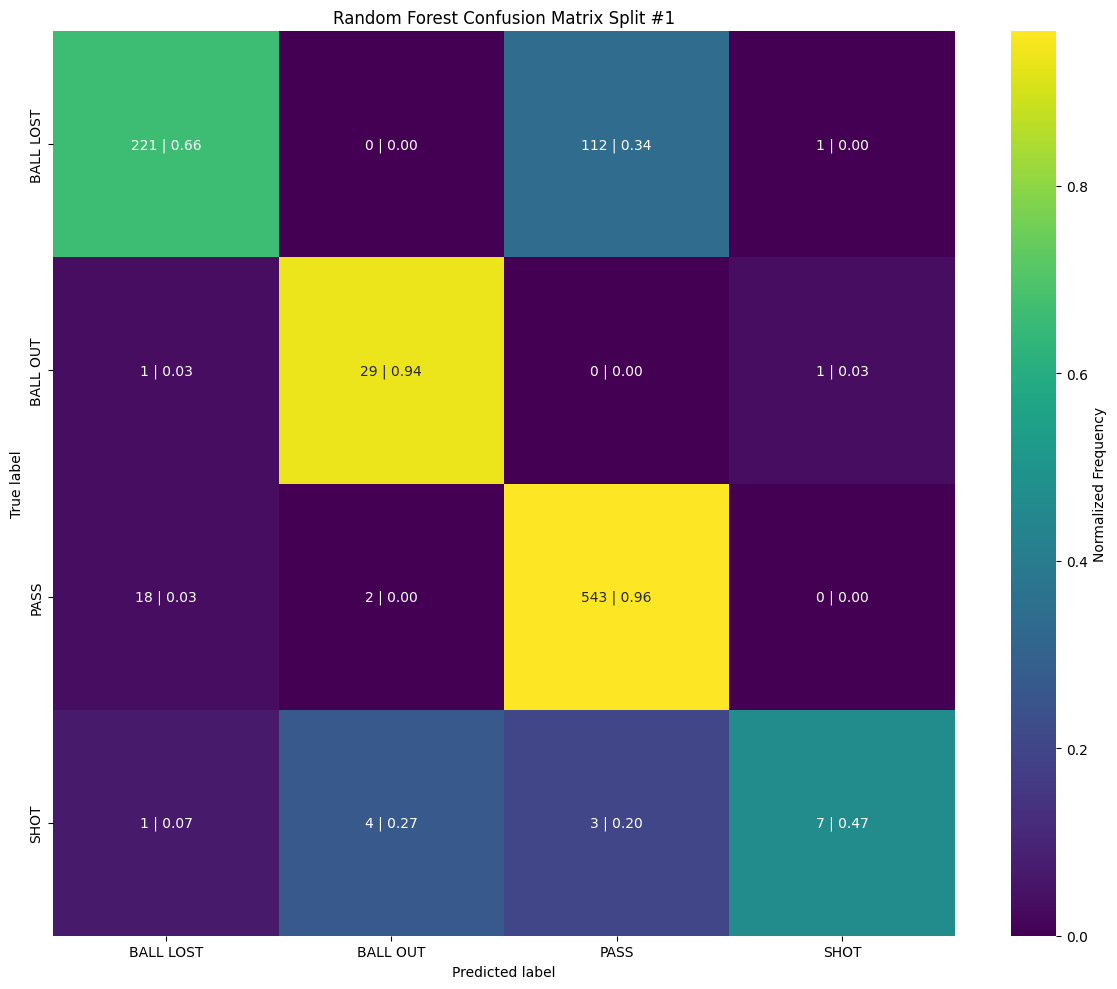

Random Forest training accuracy: 100.00%
Random Forest testing accuracy: 84.84%

Random Forest testing precision: 85.71%
Random Forest testing recall: 84.84%
Random Forest testing f1: 84.15%




In [40]:
model = RandomForestClassifier(n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

labels = np.unique(y_train)
        
fig = plot_confusion_matrix(y_train=y_train, y_train_pred=y_train_pred, y_test=y_test, 
                            y_pred=y_test_pred, labels=labels, split=0, model_name="Random Forest")   
fig.savefig(f"X_3-test.png", bbox_inches="tight")

In [69]:
import pandas as pd

df1 = pd.DataFrame({'A': [1, 2], 'B': [3, 4]})
df2 = pd.DataFrame({'A': [5, 6], 'B': [7, 8]})

result = pd.concat([df1, df2])
result

,A,B
0,1,3
1,2,4
0,5,7
1,6,8


In [68]:
skill = skillcorner.load(
    meta_data="match_data.json",
    raw_data="structured_data.json",
    include_empty_frames=False,
    coordinates="metrica"
).to_df()

In [70]:
skill

,period_id,timestamp,frame_id,ball_state,ball_owning_team_id,ball_x,ball_y,ball_z,ball_speed,7638_x,...,away_anon_10663_d,away_anon_10663_s,away_anon_10674_x,away_anon_10674_y,away_anon_10674_d,away_anon_10674_s,away_anon_10673_x,away_anon_10673_y,away_anon_10673_d,away_anon_10673_s
0,1,0 days 00:00:00,1833,None,NaN,NaN,NaN,NaN,None,0.286359,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
1,1,0 days 00:00:00.100000,1834,None,NaN,NaN,NaN,NaN,None,0.287093,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
2,1,0 days 00:00:00.200000,1835,None,NaN,NaN,NaN,NaN,None,0.287707,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
3,1,0 days 00:00:00.300000,1836,None,NaN,NaN,NaN,NaN,None,0.288795,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
4,1,0 days 00:00:00.400000,1837,None,NaN,NaN,NaN,NaN,None,0.289064,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34014,2,0 days 00:49:54.200000,72103,None,139.0,0.936581,-0.020465,0.063876,None,NaN,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
34015,2,0 days 00:49:54.300000,72104,None,139.0,0.941653,-0.024549,0.039067,None,NaN,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
34016,2,0 days 00:49:54.400000,72105,None,139.0,0.946676,-0.028225,0.018283,None,NaN,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
34017,2,0 days 00:49:54.500000,72106,None,139.0,0.951649,-0.031491,0.001524,None,NaN,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None


In [6]:
import json
import pickle

In [7]:
data_file = "test_data.pkl"

In [8]:
with open(data_file, 'rb') as f:
    data = pickle.load(f)

In [17]:
total = 0
for k, v in data.items():
    print(v.shape)
    total += v.shape[0]
print(total)

(127, 46)
(318, 46)
(89, 46)
534
